# Red Neuronal para Clasificación no Lineal

In [2]:
#I don't think this is needed for this one; !pip install ipympl

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import seaborn
from _collections_abc import Callable
from google.colab import output

# I think we won't use this, this time
# %matplotlib inline
# %matplotlib widget
# output.enable_custom_widget_manager()

Cree los datos de entrada y sus etiquetas:

<Axes: xlabel='x', ylabel='y'>

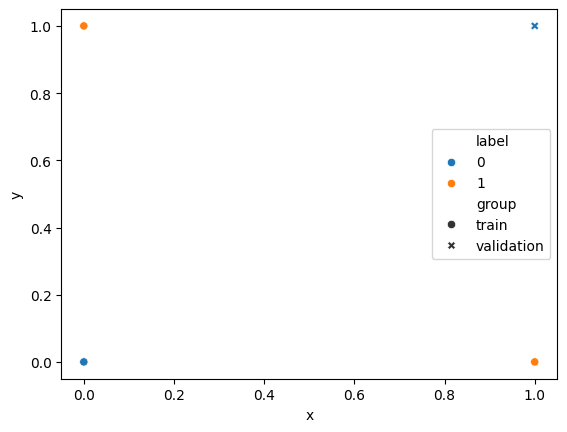

In [4]:
#Generate and split data
full_data = [((0,0),0),((0,1),1), ((1,0),1), ((1,1),0)]
random.shuffle(full_data)
train_data = full_data[:3] #Obtener los primeros 3 elementos (~75% de data)
validation_data = full_data[3:] #Obtener el resto: 1 elemento (~25% de data)

#Assign training data and their tags
X = [data[0] for data in train_data]
y = [data[1] for data in train_data]

#Show generated data
# Get full data
data_dict:dict = {"x":[], "y":[], "label":[], "group":[]}
for item in train_data:
  data_dict["x"].append(item[0][0])
  data_dict["y"].append(item[0][1])
  data_dict["label"].append(item[1])
  data_dict["group"].append("train")
for item in validation_data:
  data_dict["x"].append(item[0][0])
  data_dict["y"].append(item[0][1])
  data_dict["label"].append(item[1])
  data_dict["group"].append("validation")
# Graph
seaborn.scatterplot(data=pd.DataFrame(data_dict),x="x",y="y",hue="label", style="group")

Abstracción de Red Neuronal

Capa de Red Feedforward

In [16]:
#Models a whole hidden layer of a feedforward network
class feedforward_layer:
  def __init__(self, entry_data_size:int, neurons:int, activation_func:Callable[[float],float], derivated_activation_func:Callable[[float],float]):
    self.neurons:int = neurons
    self.activation_func:Callable[[float],float] = activation_func
    self.derivated_activation_func:Callable[[float],float] = derivated_activation_func
    self.weights:list[list[float]] = []
    self.biases:list[float] = []
    for i in range(neurons):
      neuron_weight = []
      for j in range(entry_data_size):
        neuron_weight.append(1 - 2*random.random())
      self.weights.append(neuron_weight)
      self.biases.append(0)
    self.Z:list[float] = None #Argument of the activation function
    self.A:list[float] = None #Layer output

  def forward_pass(self, prev_output:list[float]) -> list[float]:
    self.Z = []
    self.A = []
    for item in zip(self.weights,self.biases):
      neuron_weight = item[0]
      neuron_z = 0
      for elem in zip(prev_output, neuron_weight):
        neuron_z += elem[1]*elem[0]
      neuron_z += item[1] #Add the neuron's bias
      self.Z.append(neuron_z)
      self.A.append(self.activation_func(neuron_z))
    return self.A

  @property
  def get_weights(self) -> list[list[float]]:
    return self.weights.copy()
  @property
  def output(self) -> list[float]:
    return self.A.copy()

  def self_delta(self, next_weights:list[list[float]], next_delta:np.ndarray, gradient_value:np.ndarray)->np.ndarray:
    W_array = np.array(next_weights)
    delta_prop = np.matmul(W_array.T, next_delta)
    delta = delta_prop * gradient_value
    return delta

  def backpropagation(self, learn_rate:float, prev_output:list[float], next_weights:list[list[float]], next_delta:np.ndarray, gradient_value:np.ndarray) -> None:
    delta_T = (self.self_delta(next_weights, next_delta, gradient_value)).T
    adjust_matrix = learn_rate * delta_T

    new_weights = []
    for item in zip(self.weights, np.matmul(adjust_matrix, np.array(prev_output))):
      neuron_weight = []
      for elem in zip(item[0], item[1]):
        neuron_weight.append(elem[0] - elem[1])
      new_weights.append(neuron_weight)
    self.weights = new_weights

    new_biases = []
    for item in zip(self.biases, adjust_matrix):
      new_biases.append(item[0] - item[1])
    self.biases = new_biases

#Models the entry layer of the network, sets activation function as identity so that the data is not modified on entry
class input_feedforward_layer(feedforward_layer):
  def __init__(self, entry_data_size:int):
    super().__init__(entry_data_size, entry_data_size, lambda x: x, lambda x: 0)

  def backpropagation(self, learn_rate:float, prev_output:list[float], next_weights:list[list[float]], next_delta:np.ndarray, gradient_value:np.ndarray) -> None:
    pass

#Models the output layer of the network
class output_feedforward_layer(feedforward_layer):
  @property
  def gradient(self)->np.ndarray:
    gradient = []
    for item in self.Z:
      gradient.append(self.derivated_activation_func(item))
    return np.array(gradient)

  def self_delta(self, expected_values:list[float])->np.ndarray:
    error_matrix:list[float] = []
    for item in zip(expected_values, self.A):
      error_matrix.append(item[0] - item[1])
    delta = []
    for item in zip(error_matrix, self.gradient):
      delta.append(item[0] * item[1])
    return np.array(delta)

  def backpropagation(self, expected_values:list[float], learn_rate:float, prev_output:list[float]) -> None:
    delta_T = (self.self_delta(expected_values)).T
    adjust_matrix = learn_rate * delta_T

    new_weights = []
    for item in zip(self.weights, np.matmul(adjust_matrix, np.array(prev_output))):
      neuron_weight = []
      for elem in zip(item[0], item[1]):
        neuron_weight.append(elem[0] - elem[1])
      new_weights.append(neuron_weight)
    self.weights = new_weights

    new_biases = []
    for item in zip(self.biases, adjust_matrix):
      new_biases.append(item[0] - item[1])
    self.biases = new_biases

#Models the feedforward network / "Multilayer Perceptron"
class feedforward_network:
  def __init__(self, network_structure:list[int], activation_functions:list[Callable[[float],float]], derivated_activation_functions:list[Callable[[float],float]], tolerance = np.power(10.0, -5)):
    self.layers: list[feedforward_layer] = []
    self.tolerance: float = tolerance

    prevLayerSize:int = 0
    for item in enumerate(network_structure, 1): #Start enumeration at index = 1
      if item[0] == 1:
        self.layers.append(input_feedforward_layer(item[1]))
        self.entry_size:int = item[1]
      elif ( item[0] < len(network_structure) ):
        self.layers.append(feedforward_layer(prevLayerSize, item[1], activation_functions[item[0] - 2], derivated_activation_functions[item[0] - 2]))
      else:
        self.layers.append(output_feedforward_layer(prevLayerSize, item[1], activation_functions[item[0] - 2], derivated_activation_functions[item[0] - 2]))
        self.output_size:int = item[1]
      prevLayerSize = item[1]

  @property
  def get_entry_size(self) -> int:
    return self.entry_size
  @property
  def get_output_size(self) -> int:
    return self.output_size

  def predict(self, data:list[list[float]]) -> list[list[float]]:
    output:list[list[float]] = []
    for item in data:
      prev_output:list[float] = item
      for layer in self.layers:
        prev_output = layer.forward_pass(prev_output)
      output.append(prev_output)
    return output

  #Trains the model for the desired number of epochs, returns a list of (index, error) per-epoch
  def train(self, train_data:list[list[float]], tags:list[list[float]], learn_rate:float, epochs:int = 200, printEach:int = None) -> list[tuple[int,float]]:
    errorList:list[tuple[int,float]] = []
    acc:int = 0
    big_acc:int = 1
    for i in range(epochs):
      errorAvg:float = 0
      #Train with all data each epoch
      for data, tag in zip(train_data,tags):
        #Do forward-pass
        output:list[float] = data
        for layer in self.layers:
          output = layer.forward_pass(output)

        #Calculate partial error
        error:float = 0
        for value in zip(output, tag):
          error += (1/(2*len(tag))) * np.power(value[0] - value[1], 2)
        errorAvg += (1/len(tags)) * error

        #Do backpropagation
        for index, layer in enumerate(reversed(self.layers),0):
          gradient:list[float] = None
          prev_delta:np.ndarray = None
          prev_output:list[float] = self.layers[-2 - index].output

          if (index == 0): #The current layer is the output layer
            gradient = layer.gradient
            prev_delta = layer.self_delta(tag)
            layer.backpropagation(tag, learn_rate, prev_output)
          elif (index < len(self.layers) - 1): #The current layer is a hidden layer
            layer.backpropagation(learn_rate, prev_output, self.layers[index+1].weights, prev_delta, gradient)
            prev_delta = layer.self_delta(self.layers[index+1].weights, prev_delta, gradient)
          #The input layer does not require backpropagation
      #Add error of current epoch to list
      errorList.append( (i+1, errorAvg) )

      #If desired, print progress when iteration reached
      if (printEach is not None):
        acc += 1
        if (acc >= printEach):
          print(f"Iteration {acc*big_acc} reached")
          big_acc += 1
          acc = 0

      #Check if tolerance threshold was reached
      if (errorAvg < self.tolerance):
        break
    return errorList


Defina la función de activación y su derivada:

In [7]:
def sigmoid(x):
    # Definicion de la función sigmoide
    return 1/(1 + math.exp(-x))

def dsigmoid(x):
    # Definicion de la derivada de la función sigmoide
    return sigmoid(x)*(1 - sigmoid(x))

def r_sigmoid_create(r):
  return (lambda x: sigmoid(r*x))

def r_dsigmoid_create(r):
  return (lambda x: dsigmoid(r*x)*r)

## Entrenamiento de la red neuronal

Use el esquema de "Retropropagación" para entrenar la red.

In [32]:
# Build activation functions
activation_functions = [r_sigmoid_create(10), r_sigmoid_create(1000)]
# Build derivated functions
deriv_activation_functions = [r_dsigmoid_create(10), r_dsigmoid_create(1000)]
# Assemble network
network = feedforward_network([2,2,1], activation_functions, deriv_activation_functions)

# Split train data between data and tags
only_data = [ list(item) for item in X]
only_tags = [ [item] for item in y]
# Train network
print(network.predict([[1,2],[1,1]]))
#network.train(only_data, only_tags, np.power(10.0, -5), printEach=20)


[[0.462657972619888], [0.005894290573602485]]


In [ ]:
# Merely encapsulating the prediction process
# NOTE. Only use after training
def predict_data(data:list[tuple[float,float]]) -> list[float]:
  global w1, w2, w3, b1, b2, b3
  label_list:list[float] = []
  for item in data:
    result1 = forward_step(list(item), list(w1), b1, sigmoid)
    result2 = forward_step(list(item), list(w2), b2, sigmoid)
    result3 = forward_step([result1[0], result2[0]], list(w3), b3, sigmoid)
    label_list.append(result3[0])
  return label_list

Valide del entrenamiento. Con una gráfica del error en funcion de las épocas.

In [ ]:
# Gráfica Error vs. Épocas
grafica = plt.figure().add_subplot()
grafica.plot(errorList[0], errorList[1], color = "red")
plt.show()

In [ ]:
# Get actual labels
x: list[float] = []
y: list[float] = []
labels: list[float] = []
for i in range(0, len(validation_data)):
  x.append(validation_data[i][0][0])
  y.append(validation_data[i][0][1])
  labels.append(validation_data[i][1])

# Get predicted labels
input_data = [item[0] for item in validation_data]
labels_pred : list[float] = predict_data(input_data)

# Graph actual versus predictions
grafica = plt.figure().add_subplot(projection = "3d")
grafica.scatter(x, y, labels, color = "blue")
grafica.scatter(x, y, labels_pred, color = "red")
plt.show()

# Calculate MSE
error = 0
for item in zip(labels, labels_pred):
  error += np.power(item[0] - item[1], 2)
error = error / len(labels)
print("Mean Squared Error\n", error)

Support for third party widgets will remain active for the duration of the session. To disable support:

## Probando con Keras

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

training_x: list[float] = []
training_y: list[float] = []
training_labels: list[float] = []


from sklearn import preprocessing

data = []
tag = []
for item in train_data:
  data.append(item[0])
  tag.append(item[1])
scaler = preprocessing.StandardScaler().fit(np.array(data))
# min_tag = min(tag)
# tag = [value - min_tag for value in tag] #Rescale tags for interval [0,1]
postprocess = [scaler.transform(np.array(data)), tag]
#Refill
data = []
for value in zip(postprocess[0], postprocess[1]):
  data.append( (tuple(value[0]), value[1]) )
scaled_train_data = data

for i in range(0, len(scaled_train_data)):
  training_x.append(scaled_train_data[i][0][0])
  training_y.append(scaled_train_data[i][0][1])
  training_labels.append(scaled_train_data[i][1])

model = keras.Sequential()
model.add(layers.Dense(units = 2, activation = "sigmoid", input_dim = 2))
model.add(layers.Dense(units = 1, activation = "sigmoid"))
#model.add(keras.Input(shape = (2,)))
model.build()
#optimizer = keras.optimizers.SGD()
model.compile(optimizer = keras.optimizers.SGD(), loss = keras.losses.MeanSquaredError())
model.summary()
#lst = [np.array(training_x), np.array(training_y)]
lst = np.array([np.array(item) for item in zip(training_x, training_y)])
lbls = np.array([np.array(item) for item in training_labels])
print(np.array(lst).shape)
#arr = np.array(lst)


model.fit(lst, lbls, epochs = 500)


In [ ]:
eval_lst = np.array([np.array(item) for item in zip(x, y)])

predict_lbls = model.predict(eval_lst)

In [ ]:
grafica = plt.figure().add_subplot(projection = "3d")
grafica.scatter(x, y, labels, color = "blue")
grafica.scatter(x, y, predict_lbls, color = 'orange')
plt.show()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()